In [26]:
from math import sqrt,ceil, floor


In [27]:
import numpy as np
def arbre_recomb(n,b): #arbre avec recombinaison sous forme de tableau
    l=2*b*n+1
    S=np.zeros((l,n+1))
    for i in range(1,n+1):
        for j in range(l):
            if j<b*n :
                for k in range(b*(n-i),b*n):
                    S[k,i]=b*n-k
            if j>b*n:
                S[j,i]=-S[2*b*n-j,i]
    return S

In [28]:
def arbre_recomb2(n,b):
    l=2*b*n+1
    S=np.zeros((l,n+1))
    for i in range(l):
        S[i,n]= b*n-i
    for j in range(1,n+1):
        for i in  range(l):
            if i>=b*j and i<=b*(2*n-j):
                S[i,n-j]=b*n-i
    return S


In [29]:
arbre_recomb2(1000,2)

array([[    0.,     0.,     0., ...,     0.,     0.,  2000.],
       [    0.,     0.,     0., ...,     0.,     0.,  1999.],
       [    0.,     0.,     0., ...,     0.,  1998.,  1998.],
       ...,
       [    0.,     0.,     0., ...,     0., -1998., -1998.],
       [    0.,     0.,     0., ...,     0.,     0., -1999.],
       [    0.,     0.,     0., ...,     0.,     0., -2000.]])

In [30]:
def proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n):
    proba=np.zeros((3,len(List_sigma)))
    h=T/n
    for i in range(len(List_sigma)):
        proba[0,i]=(List_sigma[i]**2+List_a[i]*Liste_saut[i]*sigma_bar*np.sqrt(h)+h*List_a[i]**2)/(2*(Liste_saut[i]*sigma_bar)**2)
        proba[1,i]=(List_sigma[i]**2-List_a[i]*Liste_saut[i]*sigma_bar*np.sqrt(h)+h*List_a[i]**2)/(2*(Liste_saut[i]*sigma_bar)**2)
        proba[2,i]=1-(proba[0,i]+proba[1,i])
    return proba

In [69]:
arbre=arbre_recomb2(2500,3)

In [68]:
kappa = 3.0
theta = 0.04
sigma_v = 0.1
r = 0.05
rho = -0.1 # covariance between price and volatility brownian motions
v0 = 0.04
sigma_bar = 0.2

In [33]:
def prix_call_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
        
    return table_prix

In [34]:
dw = 0.02

In [35]:
ml, mu=  15, 40
m = mu-ml+1
regimes = range(m)

In [36]:
# Compute the Markov chain

# upper and lower bounds for the discretization of the volatility


def transition(k):

    forward = sigma_v**2/(2*(dw)**2) + (2*kappa*theta-sigma_v**2)/(2*k*(dw)**2) - kappa*k/4

    backward = sigma_v**2/(2*(dw)**2) - (2*kappa*theta-sigma_v**2)/(2*k*(dw)**2) + kappa*k/4

    return forward,backward


def transition(k):

    forward = sigma_v**2/(2*(dw)**2) + (2*kappa*theta-(sigma_v**2)/2)/(2*k*(dw)**2) - kappa*k/4

    backward = sigma_v**2/(2*(dw)**2) - (2*kappa*theta-(sigma_v**2)/2)/(2*k*(dw)**2) + kappa*k/4

    return forward,backward


def compute_Q():
    
    Q = np.zeros((m,m))

    for i in range(1,m-1):
        
        forward,backward = transition(i+ml-1)

        if forward>=0 and backward>=0:

            Q[i,i+1] = forward
            Q[i,i-1] = backward
            Q[i,i] = -(forward+backward)

        elif forward>0:

            Q[i,i-1] = backward + kappa*(i+ml-1)/4
            Q[i,i+1] = sigma_v**2/(2*(dw)**2) 
            Q[i,i] = -forward-backward

        else:
            
            Q[i,i-1] = sigma_v**2/(2*(dw)**2) 
            Q[i,i+1] = forward - kappa*(i+ml-1)/4
            Q[i,i] = -forward-backward
    # i =0
    Q[0,1] = (2*kappa*theta-(sigma_v**2)/2)/(ml*(dw)**2) - kappa*ml/2
    Q[0,0] = - Q[0,1]
    # i = m-1
    Q[m-1,m-2] = -(2*kappa*theta-(sigma_v**2)/2)/(mu*(dw)**2) + kappa*mu/2
    Q[m-1,m-1] = - Q[m-1,m-2]

    return Q

In [37]:
def transition_matrix(Q,h):
    nbr=Q.shape[0]
    tr_matrix=np.zeros((nbr,nbr))
    for i in range(nbr):
        for j in range(nbr):
            if i==j:
                tr_matrix[i,j]=np.exp(Q[i,j]*h)
            else:
                tr_matrix[i,j]=-(1-np.exp(Q[i,i]*h))*Q[i,j]/Q[i,i]
    tr_matrix = np.nan_to_num(tr_matrix, nan=0)
    return tr_matrix


In [54]:
Q=np.array([[-0.5,0.5],[0.5,-0.5]])
P=transition_matrix(Q,1/1000)

In [55]:
Q1=compute_Q()
P1=transition_matrix(Q1,0.25/2500)

In [56]:
P1

array([[ 9.98334721e-01,  1.66527855e-03,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 4.16146267e-04,  9.97503122e-01,  2.08073134e-03,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00

In [57]:
L1=[0.15,0.25]
L2=[0.05-0.5*0.15**2 ,0.05-0.5*0.25**2 ]
L3=[1,2]
L4=[0.05,0.05]

In [58]:
def liste_saut(nbr_reg,liste_sigma,liste_a):
    liste_saut = [0]*nbr_reg
    for i in range (nbr_reg):
        k1,k2 = floor(2*liste_sigma[i]/sigma_bar),ceil(2*liste_sigma[i]/sigma_bar)
        if k1==k2 or k1*sigma_bar<liste_sigma[i]:
            liste_saut[i] = k2
        else:
            c = ((k1*sigma_bar)**2-liste_sigma[i]**2)/liste_a[i]**2
            d = (k2*sigma_bar-sqrt((k2*sigma_bar)**2-4*liste_sigma[i]**2))**2/(4*liste_a[i])**2
            if c<=d:
                liste_saut[i] = k2
            else:
                liste_saut[i] = k1
    return liste_saut

In [59]:
L5=liste_saut(2,L1,L2)

In [60]:
L5

[2, 5]

In [70]:
list_vi = [(1/4)*((i+ml-1)*dw)**2 for i in range(1,m+1)]
list_sigma = [np.sqrt(list_vi[i]*(1-rho**2)) for i in range(len(list_vi))]
list_a = [list_vi[i]*((rho*kappa/sigma_v)-0.5) for i in range(len(list_vi))]

list_saut = [0]*m
for i in range (m):
    k1,k2 = floor(2*list_sigma[i]/sigma_bar),ceil(2*list_sigma[i]/sigma_bar)
    if k1==k2 or k1*sigma_bar<list_sigma[i]:
        list_saut[i] = k2
    else:
        c = ((k1*sigma_bar)**2-list_sigma[i]**2)/list_a[i]**2
        d = (k2*sigma_bar-sqrt((k2*sigma_bar)**2-4*list_sigma[i]**2))**2/(4*list_a[i])**2
        if c<=d:
            list_saut[i] = k2
        else:
            list_saut[i] = k1

list_r = [0.05]*m

In [63]:
proba_up_middle_down(L1,L2,L3,0.2,1,1000)

array([[0.28433223, 0.19605476],
       [0.27820531, 0.19457244],
       [0.43746246, 0.6093728 ]])

In [22]:
A1=prix_call_europeen(100,90,1000,5,0.1,1,L1,L2,L5,L4,P)

IndexError: index 4001 is out of bounds for axis 0 with size 4001

In [48]:
A1[:,0][1000*5]

{0: 4.046924472089168, 1: 6.275787071333176}

In [23]:
A1=prix_call_europeen(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)
A2=prix_call_europeen(100,96,1000,2,0.2,1,L1,L2,L3,L4,P)
A3=prix_call_europeen(100,98,1000,2,0.2,1,L1,L2,L3,L4,P)
A4=prix_call_europeen(100,100,1000,2,0.2,1,L1,L2,L3,L4,P)
A5=prix_call_europeen(100,102,1000,2,0.2,1,L1,L2,L3,L4,P)
A6=prix_call_europeen(100,104,1000,2,0.2,1,L1,L2,L3,L4,P)
A7=prix_call_europeen(100,106,1000,2,0.2,1,L1,L2,L3,L4,P)

In [24]:
A = [A1, A2, A3, A4, A5, A6, A7]

In [25]:
import pandas as pd
Df1 = pd.DataFrame({'S0':[i for i in range(94,107,2)], 'Tree':[B[:,0][2000] for B in A]})
Df1

C:\Users\yoneh\AppData\Local\Temp\ipykernel_14332\404225768.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


,S0,Tree
0,94,"{0: 5.86121169713768, 1: 8.228404386030418}"
1,96,"{0: 6.923020326921834, 1: 9.317382007445124}"
2,98,"{0: 8.083383992632376, 1: 10.477573544944184}"
3,100,"{0: 9.338299622468098, 1: 11.704247134436248}"
4,102,"{0: 10.683620427004527, 1: 13.000574946330795}"
5,104,"{0: 12.111348355527737, 1: 14.356138588476941}"
6,106,"{0: 13.61462223374124, 1: 15.772456149244976}"


In [49]:
def prix_put_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(K-S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
        
    return table_prix

In [50]:
def prix_call_americain(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
                    table_prix[i,n-j][etat]=max(table_prix[i,n-j][etat],-K+S_o*np.exp(arbre[i,n-j]*sigma_bar*np.sqrt(h)))
        
    return table_prix

In [51]:
def prix_put_americain(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(K-S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
                    table_prix[i,n-j][etat]=max(table_prix[i,n-j][etat],K-S_o*np.exp(arbre[i,n-j]*sigma_bar*np.sqrt(h)))
        
    return table_prix

In [25]:
C1=prix_put_americain(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)
C2=prix_put_americain(100,96,1000,2,0.2,1,L1,L2,L3,L4,P)
C3=prix_put_americain(100,98,1000,2,0.2,1,L1,L2,L3,L4,P)
C4=prix_put_americain(100,100,1000,2,0.2,1,L1,L2,L3,L4,P)
C5=prix_put_americain(100,102,1000,2,0.2,1,L1,L2,L3,L4,P)
C6=prix_put_americain(100,104,1000,2,0.2,1,L1,L2,L3,L4,P)
C7=prix_put_americain(100,106,1000,2,0.2,1,L1,L2,L3,L4,P)

In [26]:
C=[C1, C2, C3, C4, C5, C6, C7]

In [29]:
Df2 = pd.DataFrame({'S0':[i for i in range(94,107,2)], 'Tree':[B[:,0][2000] for B in C]})
Df2

,S0,Tree
0,94,"{0: 7.887341803269553, 1: 10.246044855314704}"
1,96,"{0: 6.761619788250978, 1: 9.211130469447333}"
2,98,"{0: 5.77279975983544, 1: 8.263628289981797}"
3,100,"{0: 4.909105962224006, 1: 7.397754729040091}"
4,102,"{0: 4.15974578321561, 1: 6.6126611028022015}"
5,104,"{0: 3.5125898797011983, 1: 5.898792664675986}"
6,106,"{0: 2.9567023364071985, 1: 5.254773500702386}"


In [52]:
def prix_call_europeen_Heston_model(K,S_o,n,b,sigma_bar,T,List_vi,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1),dtype=object)
    for i in range(l):
        table_prix[i,n]={reg:max(-K+S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0) for reg in range(len(List_sigma))}
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                table_prix[i,n-j]={reg:0 for reg in range(len(List_sigma))}
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j][etat] += P[etat,k]*(table_prix[i-saut,n-j+1][k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1][k]*proba_umd[1,etat]+table_prix[i,n-j+1][k]*proba_umd[2,etat])
                    table_prix[i,n-j][etat]=np.exp(-r*h)*table_prix[i,n-j][etat]
        
    return table_prix

In [26]:
r=0.05
B=prix_call_europeen_Heston_model(100,90,2500,3,0.2,0.25,list_vi,list_sigma,list_a,list_saut,list_r,P1)

IndexError: index 2500 is out of bounds for axis 1 with size 1001

In [ ]:
B[:,0][2500*3]

In [53]:
def prix_call_europeen2(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,P):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma)))
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    for k in range(len(List_sigma)):
                        table_prix[i,n-j,etat] += P[etat,k]*(table_prix[i-saut,n-j+1,k]*proba_umd[0,etat]+table_prix[i+saut,n-j+1,k]*proba_umd[1,etat]+table_prix[i,n-j+1,k]*proba_umd[2,etat])
                    table_prix[i,n-j,etat]=np.exp(-r*h)*table_prix[i,n-j,etat]
        
    return table_prix

In [30]:
A1_1=prix_call_europeen(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)


In [22]:
A1_1[:,0][2500*3]

{0: 1.2100619313471626, 1: 2.7027109319967293}

In [23]:
A1_2=prix_call_europeen2(100,94,2500,3,0.2,0.25,L1,L2,L3,L4,P)

In [24]:
A1_2[:,0][2500*3]

array([1.21006193, 2.70271093])

In [54]:
import numpy as np
from numpy import sqrt, exp, pi, cos, sin, log, abs



def Fourier_Heston_Put(S0, K, T, r, 
                  # Heston Model Paramters
                  kappa, # Speed of the mean reversion 
                  theta, # Long term mean
                  rho,   # correlation between 2 random variables
                  zeta,  # Volatility of volatility
                  v0,    # Initial volatility 
                  opt_type,
                  N = 1_012,
                  z = 24
                  ):

  def heston_char(u): 
    t0 = 0.0 ;  q = 0.0
    m = log(S0) + (r - q)*(T-t0)
    D = sqrt((rho*zeta*1j*u - kappa)**2 + zeta**2*(1j*u + u**2))
    C = (kappa - rho*zeta*1j*u - D) / (kappa - rho*zeta*1j*u + D)
    beta = ((kappa - rho*zeta*1j*u - D)*(1-exp(-D*(T-t0)))) / (zeta**2*(1-C*exp(-D*(T-t0))))
    alpha = ((kappa*theta)/(zeta**2))*((kappa - rho*zeta*1j*u - D)*(T-t0) - 2*log((1-C*exp(-D*(T-t0))/(1-C))))
    return exp(1j*u*m + alpha + beta*v0)
  
  # # Parameters for the Function to make sure the approximations are correct.
  c1 = log(S0) + r*T - .5*theta*T
  c2 = theta/(8*kappa**3)*(-zeta**2*exp(-2*kappa*T) + 4*zeta*exp(-kappa*T)*(zeta-2*kappa*rho) 
        + 2*kappa*T*(4*kappa**2 + zeta**2 - 4*kappa*zeta*rho) + zeta*(8*kappa*rho - 3*zeta))
  a = c1 - z*sqrt(abs(c2))
  b = c1 + z*sqrt(abs(c2))
  
  h       = lambda n : (n*pi) / (b-a) 
  g_n     = lambda n : (exp(a) - (K/h(n))*sin(h(n)*(a - log(K))) - K*cos(h(n)*(a - log(K)))) / (1 + h(n)**2)
  g0      = K*(log(K) - a - 1) + exp(a)
  
  F = g0 
  for n in range(1, N+1):
    h_n = h(n)
    F += 2*heston_char(h_n) * exp(-1j*a*h_n) * g_n(n)

  F = exp(-r*T)/(b-a) * np.real(F)
  F = F if opt_type == 'p' else F + S0 - K*exp(-r*T)
  return F if F > 0 else 0


In [48]:
call_heston=Fourier_Heston_Put(90,100,0.25, 0.05, kappa, theta, rho, sigma_v, v0, 'c', N = 1_012, z = 24)

In [49]:
call_heston

3.18636752581871

In [55]:


def prix_call_europeen3(K, S_o, n, b, sigma_bar, T,List_sigma, List_a, Liste_saut, List_r, P):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  # Réorganisation des dimensions de la matrice

    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] = max(-K + S_o * np.exp(arbre[i,n] * sigma_bar * np.sqrt(h)), 0)
    new_table_prix = np.zeros((len(List_sigma), l))
    for j in range(1, n + 1):  # Créer une nouvelle matrice pour chaque itération de j
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    for k in range(len(List_sigma)):
                        prix_somme += P[etat, k] * (
                                table_prix[k, i - saut] * proba_umd[0, etat] +
                                table_prix[k, i + saut] * proba_umd[1, etat] +
                                table_prix[k, i] * proba_umd[2, etat]
                        )
                    new_table_prix[etat, i] = np.exp(-r * h) * prix_somme
        table_prix ,new_table_prix= new_table_prix , table_prix # Remplacer l'ancienne matrice par la nouvelle

    return table_prix


In [34]:
A1=prix_call_europeen3(100,94,1000,2,0.2,1,L1,L2,L3,L4,P)

In [35]:
A1[:,2000]

array([5.8612117 , 8.22840439])

In [56]:


def prix_call_europeen_Heston_model2(K, S_o, n, b, sigma_bar, T,List_vi, List_sigma, List_a, Liste_saut, List_r, P):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  # Réorganisation des dimensions de la matrice

    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] = max(-K+S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0)
    new_table_prix = np.zeros((len(List_sigma), l))
    for j in range(1, n + 1): # Créer une nouvelle matrice pour chaque itération de j
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    for k in range(len(List_sigma)):
                        prix_somme += P[etat, k] * (
                                table_prix[k, i - saut] * proba_umd[0, etat] +
                                table_prix[k, i + saut] * proba_umd[1, etat] +
                                table_prix[k, i] * proba_umd[2, etat]
                        )
                    new_table_prix[etat, i] = np.exp(-r * h) * prix_somme
        table_prix ,new_table_prix= new_table_prix , table_prix  # Remplacer l'ancienne matrice par la nouvelle

    return table_prix


In [64]:
C9=prix_call_europeen_Heston_model2(100,100,2500,3,0.2,0.25,list_vi,list_sigma,list_a,list_saut,list_r,P1)

NameError: name 'prix_call_europeen_Heston_model2' is not defined

In [ ]:
C9[:,2500*3]

In [57]:
def nouveau_prix_call_europeen(K,S_o,n,b,sigma_bar,T,List_sigma,List_a,Liste_saut,List_r,Q):
    proba_umd=proba_up_middle_down(List_sigma,List_a,Liste_saut,sigma_bar,T,n)
    l=2*b*n+1
    h=T/n
    table_prix=np.zeros((l,n+1,len(List_sigma)))
    for i in range(l):
        for reg in range(len(List_sigma)):
            table_prix[i,n,reg]=max(-K+S_o*np.exp(arbre[i,n]*sigma_bar*np.sqrt(h)),0)
    for j in range(1,n+1):
        for i in range(l):
            if i>=b*j and i<=b*(2*n-j):
                for etat in range(len(List_sigma)):
                    r=List_r[etat]
                    saut=Liste_saut[etat]
                    table_prix[i,n-j,etat] += table_prix[i-saut,n-j+1,etat]*proba_umd[0,etat] + table_prix[i+saut,n-j+1,etat]*proba_umd[1,etat]+ table_prix[i,n-j+1,etat]*(proba_umd[2,etat]+Q[etat,etat]*h)
                    for k in range(len(List_sigma)):
                        if k != etat:
                            table_prix[i,n-j,etat] += Q[etat,k]*h*table_prix[i,n-j+1,k]
                    table_prix[i,n-j,etat]=np.exp(-r*h)*table_prix[i,n-j,etat]
        
    return table_prix

In [27]:
A1=nouveau_prix_call_europeen(100,94,1000,2,0.2,1,L1,L2,L3,L4,Q)

In [29]:
A1[:,0][2000]

array([5.86146927, 8.22796305])

In [71]:
def nouveau_prix_call_europeen_Heston_model(K, S_o, n, b, sigma_bar, T,List_vi, List_sigma, List_a, Liste_saut, List_r, Q):
    proba_umd = proba_up_middle_down(List_sigma, List_a, Liste_saut, sigma_bar, T, n)
    l = 2 * b * n + 1
    h = T / n
    table_prix = np.zeros((len(List_sigma), l))  

    for reg in range(len(List_sigma)):
        for i in range(l):
            table_prix[reg, i] =  max(-K+S_o*np.exp((arbre[i,n])*sigma_bar*np.sqrt(h)+(rho/sigma_v)*(List_vi[reg]-v0)+(0.05-rho*kappa*theta/sigma_v)*n*h),0)
    new_table_prix = np.zeros((len(List_sigma), l))         
    for j in range(1, n + 1): 
        for i in range(l):
            if i >= b * j and i <= b * (2 * n - j):
                for etat in range(len(List_sigma)):
                    r = List_r[etat]
                    saut = Liste_saut[etat]
                    prix_somme = 0
                    prix_somme += table_prix[etat, i - saut] * proba_umd[0, etat] + \
                                      table_prix[etat, i + saut] * proba_umd[1, etat] + \
                                      table_prix[etat, i] * (proba_umd[2, etat] + Q[etat, etat] * h)
        
                    if etat != 0 and etat != len(List_sigma)-1:
                        prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i] + Q[etat, etat+1] * h * table_prix[etat+1, i] 
                    else:
                        if etat ==0 :
                            prix_somme +=  Q[etat, etat+1] * h * table_prix[etat+1, i]
                        if etat== len(List_sigma)-1:
                            prix_somme += Q[etat, etat-1] * h * table_prix[etat-1, i] 
                    new_table_prix[etat, i] = np.exp(-r * h) * prix_somme
        table_prix, new_table_prix = new_table_prix, table_prix  

    return table_prix


In [72]:
C9=nouveau_prix_call_europeen_Heston_model(100,100,2500,3,0.2,0.25,list_vi,list_sigma,list_a,list_saut,list_r,Q1)

In [73]:
C9[:,2500*3]

array([4.94155865e+00, 4.83721727e+00, 4.75142441e+00, 4.66760301e+00,
       4.58312094e+00, 4.49731161e+00, 4.41012194e+00, 4.32163339e+00,
       4.23196868e+00, 4.14126376e+00, 4.04965780e+00, 3.95728202e+00,
       3.86420669e+00, 3.77006586e+00, 3.67042384e+00, 3.50192934e+00,
       1.26364604e+00, 4.92440439e-01, 1.49139334e-01, 6.61759209e-02,
       2.07294405e-02, 5.97594185e-03, 1.54533487e-03, 1.38633499e-03,
       5.70603499e-04, 2.49757648e-04])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


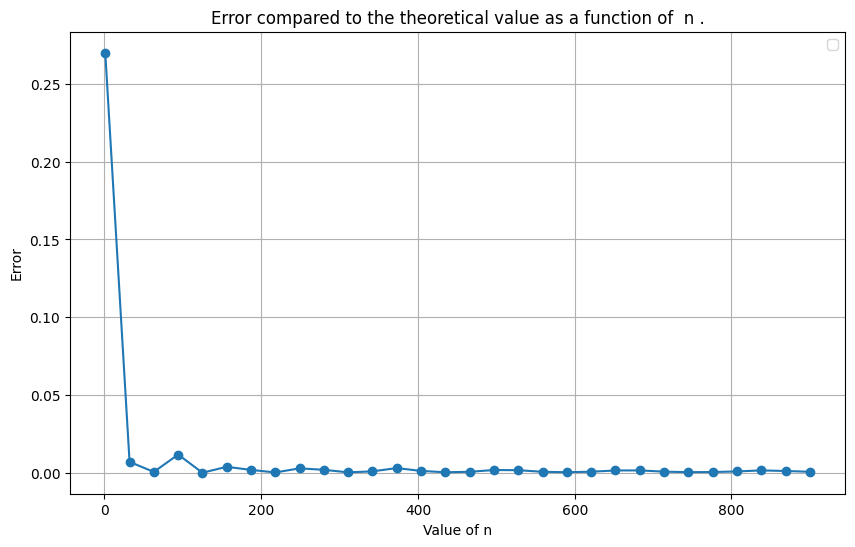

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Définir les valeurs de n
n_values = np.linspace(1, 900, 30, dtype=int)

# Définir les autres paramètres
K = 100
S_o = 94
truth = 5.8620
# Créer une figure
plt.figure(figsize=(10, 6))
R=[]
# Parcourir les valeurs de n
for n in n_values:
    P=transition_matrix(Q,1/n)
    arbre=arbre_recomb2(n,2)
    A1 = prix_call_europeen(K, S_o, n, 2, 0.2, 1, L1, L2, L3, L4, P)[:,0][n*2][0]
    R.append(A1)
plt.plot(n_values, np.abs(truth-np.array(R)), marker = "o")
# Ajouter des labels et une légende
plt.xlabel('Value of n')
plt.ylabel('Error')
plt.title('Error compared to the theoretical value as a function of  n .')
plt.legend()

# Afficher le graphique
plt.grid(True)
plt.show()


In [47]:
SensitivySigmaTable0 = np.zeros((12, 8))
SensitivySigmaTable0[:, 0] = np.tile(np.array([90.0, 100.0, 110.0]), 4)

SensitivySigmaTable1 = np.zeros((12, 8))
SensitivySigmaTable1[:, 0] = np.tile(np.array([90.0, 100.0, 110.0]), 4)

In [49]:
ctes = [(0.1, 5), (0.15, 3), (0.2, 2), (0.25, 2), (0.3, 1)]


import math

for j in range(5):
    print(j)
    arbre=arbre_recomb(1000,ctes[j][1])
    
    for i in range(3):
        EC = prix_call_europeen(K, SensitivySigmaTable0[i, 0], n, ctes[j][1], ctes[j][0], 1, L1, L2, [int(item) for item in liste_saut(2,L1,ctes[j][0],L2)], L4, P)[:,0][1000*ctes[j][1]]
        AC = prix_call_americain(K, SensitivySigmaTable0[i, 0], n, ctes[j][1], ctes[j][0], 1, L1, L2, [int(item) for item in liste_saut(2,L1,ctes[j][0],L2)], L4, P)[:,0][1000*ctes[j][1]]
        EP = prix_put_europeen(K, SensitivySigmaTable0[i, 0], n, ctes[j][1], ctes[j][0], 1, L1, L2, [int(item) for item in liste_saut(2,L1,ctes[j][0],L2)], L4, P)[:,0][1000*ctes[j][1]]
        AP = prix_call_europeen(K, SensitivySigmaTable0[i, 0], n, ctes[j][1], ctes[j][0], 1, L1, L2, [int(item) for item in liste_saut(2,L1,ctes[j][0],L2)], L4, P)[:,0][1000*ctes[j][1]]
        SensitivySigmaTable0[i, j+1] = EC[0]
        SensitivySigmaTable0[3+i, j+1] = AC[0]
        SensitivySigmaTable0[6+i, j+1] = EP[0]
        SensitivySigmaTable0[9+i, j+1] = AP[0]
        SensitivySigmaTable1[i, j+1] = EC[1]
        SensitivySigmaTable1[3+i, j+1] = AC[1]
        SensitivySigmaTable1[6+i, j+1] = EP[1]
        SensitivySigmaTable1[9+i, j+1] = AP[1]
        
#Computing MD and RD
for i in range(3):
        SensitivySigmaTable0[i, -2] = SensitivySigmaTable0[i,1:-2]
        SensitivySigmaTable0[3+i, -2] = AC[0]
        SensitivySigmaTable0[6+i, -2] = EP[0]
        SensitivySigmaTable0[9+i, -2] = AP[0]

0


KeyboardInterrupt: 